# Visualización y separación de las series por ciclo de ovulación


In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import plotly.graph_objects as go

In [12]:
DIAS_VENTANA = 10 # Número de días a tener en cuenta antes y después del momento de la ovulación
RETRASAR_OVUL = False # Si consideramos que hay que retrasar en 1 día la fecha de ovulación
#UMBRAL_DESCARTE = 0.6 # Proporción de muestras nulas para descartar una serie temporal
NUM_SERIES_ESTUDIO = 5 # Número de series temporales más representarivas a estudiar
NUM_SUJETOS_ESTUDIO = 4
RANGE_VISUALIZ = [35.0, 38.0]

In [13]:
ovulNotes = pd.read_csv('../procData/ovulNotes.csv', header=0, sep=';')
ovulNotes.timestamp = pd.to_datetime(ovulNotes.timestamp)
ovulNotes.reset_index(drop=True, inplace=True)

### Cargar los datos ya filtrados

In [14]:
tempNotes = pd.read_csv('../procData/tempNotes_filt.csv', header=0, sep=';')
tempNotes.resultTimestamp = pd.to_datetime(tempNotes.resultTimestamp, 1490195805, unit='s')

In [15]:
tempNotes.shape

(2334953, 4)

In [16]:
print(tempNotes.Tu.unique(), tempNotes.Tu.unique().size)

['TU043' 'TU021' 'AN009' 'AN010' 'TU040' 'TU022' 'TU084' 'TU064' 'AN014'
 'TU081' 'TU030' 'TU007' 'TU048' 'TU013' 'TU086' 'TU090' 'TU058' 'AN015'
 'TU089' 'AN004' 'TU009' 'TU017' 'TU002' 'TU001' 'AN018' 'AN019' 'TU042'
 'AN006' 'TU055' 'AN012' 'TU046' 'AN013' 'TU076' 'AN016' 'TU036' 'TU003'
 'TU033' 'TU061' 'TU004' 'TU053' 'TU025' 'AN003' 'TU008' 'AN001' 'TU006'
 'TU019' 'TU060' 'TU044' 'AN005' 'TU015' 'TU018' 'TU065' 'TU063' 'TU074'
 'TU045' 'TU049' 'TU016' 'TU038' 'AN007' 'TU091' 'TU037' 'TU034' 'TU041'
 'TU054' 'AN008' 'TU069' 'TU080' 'TU075' 'AN017' 'TU067' 'TU023' 'TU024'
 'TU014' 'TU078' 'TU082' 'TU088' 'AN002' 'AN011' 'TU083' 'TU077' 'TU027'
 'TU085' 'TU068' 'AN021' 'TU020' 'TU052 ' 'TU052' 'AN020'] 88


In [17]:
print(ovulNotes.shape[0])
#Por si hay marcas de ovulación que no correspondan con ninguna muestra
ovulNotes = ovulNotes[ovulNotes.prodId.isin(tempNotes.prodId)]
# Y, en efecto, hay 8 que no corresponden con ninguna muestra:

130


In [18]:
#Número de ovulaciones:
print("Numero de ovulaciones:", ovulNotes.shape[0])
print("Numero de sujetos de estudio:", tempNotes.Tu.unique().size)

Numero de ovulaciones: 122
Numero de sujetos de estudio: 88


### Muestras separadas por ciclo de ovulación
Alineadas con respecto al momento de la ovulación, y con los timestamps armonizados cada 2 minutos

In [19]:
muestras_ovul = {}
margen_temporal = pd.Timedelta(days=DIAS_VENTANA)
fecha_ref = pd.Timestamp('2025-01-01 00:00:00')

# Creamos tiempos comunes con 2 minutos de resolución
tiempos_completos = pd.date_range(
    start=fecha_ref - margen_temporal,
    end=fecha_ref + margen_temporal,
    freq='2min'
).to_frame(index=False, name="resultTimestamp")  # Para facilitar el merge

In [20]:
for id in tempNotes.Tu.unique():
    muestra = tempNotes[tempNotes.Tu == id].copy()

    muestra['resultTimestamp'] = pd.to_datetime(muestra['resultTimestamp'])

    # Obtener ovulaciones de este sujeto
    ovul = ovulNotes[ovulNotes.prodId.isin(muestra.prodId.unique())]

    i = 1
    for fecha_ovul in ovul.timestamp:
        fecha_ovul = pd.Timestamp(fecha_ovul)

        # Filtrar ventana alrededor de ovulación
        muestra_ovul = muestra[
            (muestra["resultTimestamp"] >= fecha_ovul - margen_temporal) &
            (muestra["resultTimestamp"] <= fecha_ovul + margen_temporal)
        ].copy()

        # Redondeamos los tiempos al minuto par anterior
        muestra_ovul['resultTimestamp'] = muestra_ovul['resultTimestamp'].apply(
            lambda x: x - pd.Timedelta(minutes=x.minute % 2,
                                        seconds=x.second,
                                        microseconds=x.microsecond)
        )

        # Eliminar duplicados temporales, si es que los hay
        muestra_ovul = muestra_ovul.drop_duplicates(subset='resultTimestamp', keep='first')

        # Alinear los tiempos con respecto a la ovulación (fecha_ref para poderlas comparar)
        muestra_ovul["resultTimestamp"] = muestra_ovul["resultTimestamp"] + (fecha_ref - fecha_ovul)

        # Hacemos un merge para completar todas las marcas temporales
        muestra_alineada = tiempos_completos.merge(
            muestra_ovul[["resultTimestamp", "result"]],
            on="resultTimestamp",
            how="left"
        )

        name = f"{id}_{i}"
        muestras_ovul[name] = {
            "serie": muestra_alineada,
            "ovul": fecha_ovul
        }

        i += 1


In [21]:
# Comprobamos que todas las series tienen la misma longitud:
longitudes = {k: len(v["serie"]) for k, v in muestras_ovul.items()}

print(set(longitudes.values()))

# Todas las series tienen la misma longitud:

{14401}


In [22]:
# Crear una lista con (id, número de valores no nulos)
numero_nulos = [
    (k, int(v["serie"]["result"].isna().sum())) for k, v in muestras_ovul.items()
]

# Ordenar de mayor a menor cantidad de valores no nulos
numero_nulos.sort(key=lambda x: x[1], reverse=False)

numero_nulos

[('TU046_3', 74),
 ('TU078_1', 279),
 ('TU074_4', 820),
 ('TU021_1', 941),
 ('TU013_2', 944),
 ('AN003_1', 1076),
 ('AN001_3', 1156),
 ('TU030_2', 1174),
 ('TU046_1', 1303),
 ('TU063_2', 1475),
 ('TU023_2', 1533),
 ('TU067_2', 1641),
 ('AN010_3', 1699),
 ('AN002_2', 1705),
 ('TU074_2', 1717),
 ('TU074_3', 1717),
 ('TU038_1', 1770),
 ('TU080_1', 1799),
 ('TU060_2', 1855),
 ('TU054_1', 1866),
 ('AN008_1', 1933),
 ('AN009_3', 1935),
 ('TU038_2', 2004),
 ('TU060_1', 2351),
 ('TU046_2', 2358),
 ('TU017_1', 2367),
 ('TU036_4', 2423),
 ('TU063_3', 2438),
 ('TU023_1', 2710),
 ('TU019_2', 2770),
 ('AN007_1', 2776),
 ('TU034_2', 2844),
 ('AN002_1', 2874),
 ('TU061_2', 2927),
 ('TU033_1', 2946),
 ('TU013_1', 2973),
 ('AN008_2', 2985),
 ('TU015_1', 2991),
 ('TU022_1', 3205),
 ('TU017_2', 3207),
 ('TU052_2', 3213),
 ('TU034_1', 3255),
 ('AN010_2', 3360),
 ('AN009_4', 3450),
 ('TU016_1', 3505),
 ('TU004_2', 3546),
 ('AN009_2', 3585),
 ('AN001_1', 3755),
 ('AN011_4', 3810),
 ('TU017_4', 4137),
 ('TU0

In [23]:
[(id, n/14401) for (id, n) in numero_nulos]

[('TU046_3', 0.005138532046385667),
 ('TU078_1', 0.019373654607318935),
 ('TU074_4', 0.05694049024373307),
 ('TU021_1', 0.06534268453579613),
 ('TU013_2', 0.0655510034025415),
 ('AN003_1', 0.07471703353933755),
 ('AN001_3', 0.08027220331921395),
 ('TU030_2', 0.08152211651968613),
 ('TU046_1', 0.09047982778973683),
 ('TU063_2', 0.10242344281647107),
 ('TU023_2', 0.10645094090688147),
 ('TU067_2', 0.11395042010971461),
 ('AN010_3', 0.11797791820012499),
 ('AN002_2', 0.11839455593361572),
 ('TU074_2', 0.11922783140059719),
 ('TU074_3', 0.11922783140059719),
 ('TU038_1', 0.12290813137976529),
 ('TU080_1', 0.12492188042497049),
 ('TU060_2', 0.12881049927088398),
 ('TU054_1', 0.12957433511561697),
 ('AN008_1', 0.13422678980626346),
 ('AN009_3', 0.13436566905076036),
 ('TU038_2', 0.13915700298590375),
 ('TU060_1', 0.16325255190611762),
 ('TU046_2', 0.1637386292618568),
 ('TU017_1', 0.1643635858620929),
 ('TU036_4', 0.1682522047080064),
 ('TU063_3', 0.16929379904173322),
 ('TU023_1', 0.1881813

In [33]:
def print_series(list_ids):
    fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h')

    for id in list_ids:
        serie = muestras_ovul[id]["serie"]

        # Convertimos las fechas a días relativos a la ovulación
        x = (serie["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y = serie["result"]

        plt.figure(figsize=(8, 4))

        # Puntos de la serie
        plt.scatter(x, y, s=7, label=f'Serie {id}', alpha=0.8, color='#2980B9')

        # Línea vertical discontinua en el día 0 (ovulación)
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
        #plt.text(0, 38.7, 'Ovulación', color='red', ha='center', va='bottom')

        # Etiquetas y título
        plt.title(f'Serie {id}')
        plt.xlabel('Día relativo a la ovulación')
        plt.ylabel('Temperatura (°C)')
        plt.grid(True)

        plt.xlim(-11, 11)
        plt.ylim(RANGE_VISUALIZ[0], RANGE_VISUALIZ[1])  

        plt.tight_layout()
        plt.show()


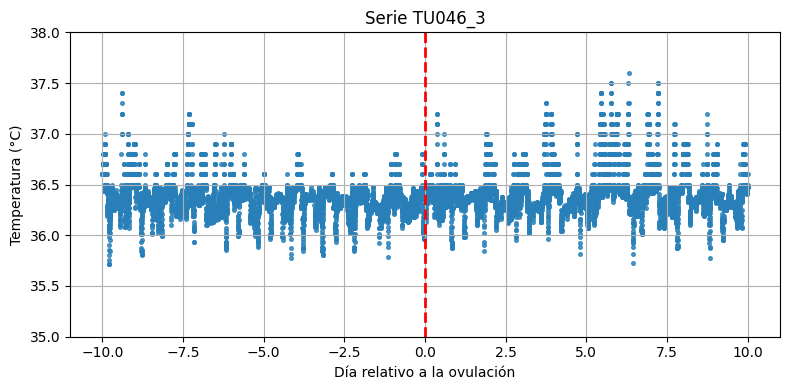

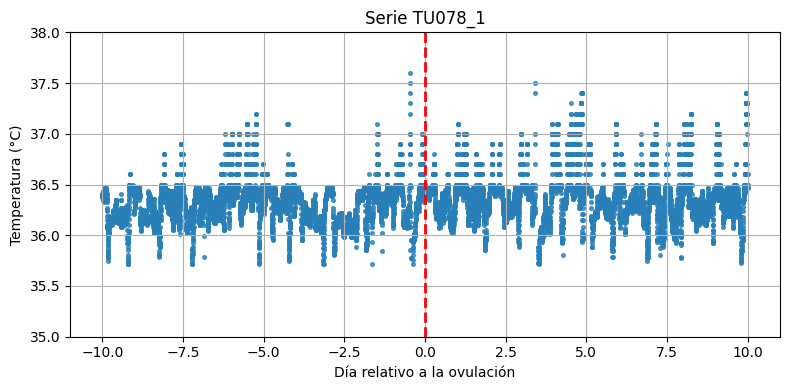

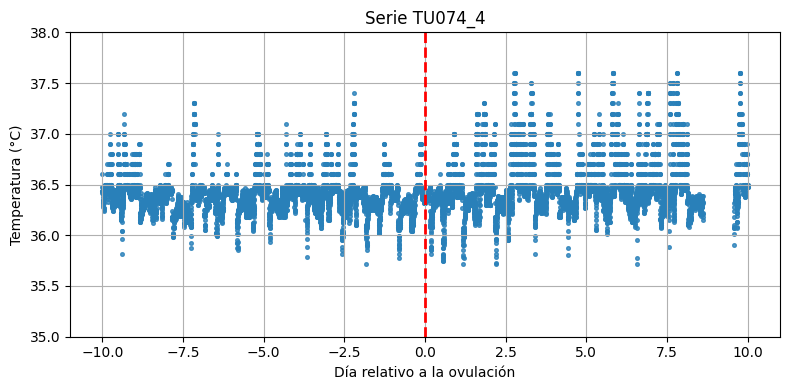

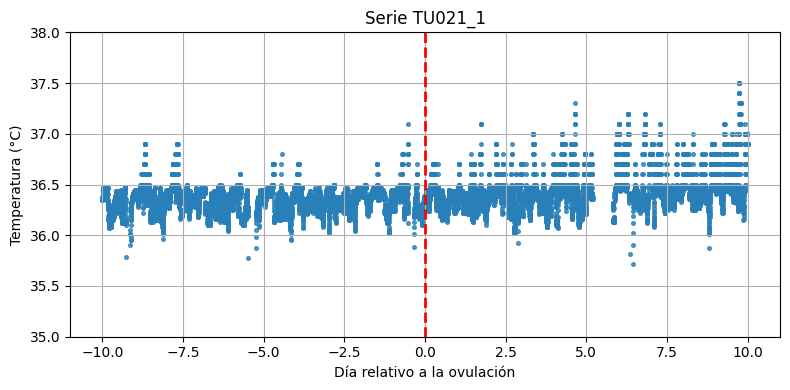

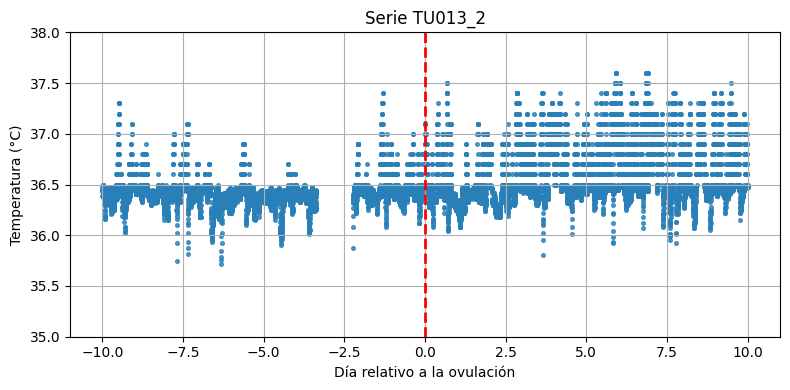

In [34]:
ids_estudio = [id for (id, n) in numero_nulos[:NUM_SERIES_ESTUDIO]]
print_series(ids_estudio)

In [35]:
def print_series_zoom(list_ids):
    fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h')

    for id in list_ids:
        serie = muestras_ovul[id]["serie"]

        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=(serie["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1),
            y=serie["result"],
            mode='markers',
            name=id,
            marker=dict(size=4, color='#2980B9'),
            line=dict(width=1)
        ))

        # Línea vertical discontinua en el día 0 (ovulación)
        fig.add_shape(
            type="line",
            x0=0,
            y0=35.5,
            x1=0,
            y1=37.7,
            line=dict(color="red", width=2, dash="dash")
        )

        fig.add_annotation(
            x=0,
            y=38.0,
            text="Ovulación",
            showarrow=False,
            yanchor="bottom",
            font=dict(color="red")
        )

        fig.update_layout(
            title=f"Serie {id}",
            xaxis_title="Día relativo a la ovulación",
            yaxis_title="Temperatura",
            hovermode="x unified",
            template="plotly_white",
            height=400
        )

        fig.update_yaxes(range=RANGE_VISUALIZ)

        fig.show()

In [36]:
print_series_zoom(ids_estudio)

In [33]:
# Guardar las series temporales con temperaturas filtradas y tiemestamps armonizados
with open("../procData/muestras_ovul_filt.pkl", "wb") as f:
    pickle.dump(muestras_ovul, f)